In [1]:
from mce_irl_pomdps import parser_pomdp
from mce_irl_pomdps import irl_pomdp_solver as irl_solver
import numpy as np

In [2]:
# Set seed for reproductibility -> IncREMENT MEMORY LEN FOR HIGHER PERFORMANCE
np.random.seed(201)
# True reward in the POMDP environment
weight = { 'poisonous' : 100, 'total_time' : 1, 'goal_reach' : 100}

In [8]:
memory_len = 1
pomdp_r = parser_pomdp.PrismModel("maze_stochastic.pm", ["P=? [F \"target\"]"], memory_len=memory_len, export=True)
# Options for the solver
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=50, maxiter_weight=50,
                      graph_epsilon=0, discount=0.999, verbose=True)
# Build the instance without side information
pomdp_r._has_sideinfo = False # Ignore the side information for the first part
irlPb_nosi = irl_solver.IRLSolver(pomdp_r, init_trust_region=4, options=options_opt)
print('-------- Optimal policy on the POMDP ---------')
# Find the optimal policy that maximizes the expected reward using Gurobi non convex solver on the problem with no side information
pol_val_grb_nosi = irlPb_nosi.from_reward_to_optimal_policy_nonconvex_grb(weight)
print('-----------------------------------------------')
# Find the optimal policy that maxpol_val_nosideinfoimizes the expected reward using the sequential convex programming scheme
# pol_val_grb_nosi = irlPb_nosi.from_reward_to_policy_via_scp(weight)
# Compute the optimal policy on the underlying MDP
print('-------- Optimal policy on the underlying MDP -----------')
pol_val_mdp = irlPb_nosi.from_reward_to_optimal_policy_mdp_lp(weight, gamma=options_opt.discount)
# Generate Trajectory of different length using the state-based policy from the MDP
print('-------- Generate trajectory from teh optimal policy on the POMDP -----------')
obs_based = True
traj_pomdp_30, rewData_pomdp_30 = pomdp_r.simulate_policy(pol_val_grb_nosi, weight, 1000, 1000, 
                                            obs_based=obs_based, stop_at_accepting_state=True)
print('----------------------------------------------------------------------------')
print('-------- Feature functions --------------')
print(irlPb_nosi.compute_feature_from_trajectory(traj_pomdp_30))
print('-----------------------------------------')
# Define some parameters when optimizing the problems
# Set the parameter for the trust region
irl_solver.trustRegion = {'red' : lambda x : ((x - 1) / 1.5 + 1),
                          'aug' : lambda x : min(10,(x-1)*1.25+1),
                          'lim' : 1+1e-4}
# Set the parameter for minimum state visitation count to be considered as zero
irl_solver.ZERO_NU_S = 1e-8
# Solve the IRL problem without side information
pomdp_r._has_sideinfo = False
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0 # /np.power(iterVal, 0.6)
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=100, maxiter_weight=100, rho=1e-3, rho_weight= 10,
                      graph_epsilon=0, discount=0.999, verbose=False, verbose_weight=True)
irlPb1 = irl_solver.IRLSolver(pomdp_r, sat_thresh=0, init_trust_region=4, rew_eps=1e-4, options=options_opt)
weight_pomdp_30, pol_pomdp_30 = irlPb1.solve_irl_pomdp_given_traj(traj_pomdp_30)
# Solve the IRL problem with side information
pomdp_r._has_sideinfo = True
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0 # /np.power(iterVal, 0.6)
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=100, maxiter_weight=100, rho=1e-3, rho_weight= 10,
                      graph_epsilon=0, discount=0.999, verbose=False, verbose_weight=True)
irlPb2 = irl_solver.IRLSolver(pomdp_r, sat_thresh=0.8, init_trust_region=4, rew_eps=1e-4, options=options_opt)
weight_pomdp_30_si, pol_pomdp_30_si = irlPb2.solve_irl_pomdp_given_traj(traj_pomdp_30)

-------- Optimal policy on the POMDP ---------
Initialize Linear subproblem to be solved at iteration k
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Parameter FeasibilityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter OptimalityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter BarConvTol to 1e-06
   Prev: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 73 rows, 102 columns and 307 nonzeros
Model fingerprint: 0x178e46b0
Model has 55 quadratic constraints
Coefficient statistics:
  Matrix range     [9e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e

/home/fdjeumou/Documents/storm_lib/MCE_IRL_POMDPS/mce_irl_pomdps/irl_pomdp_solver.py:1021: RuntimeWarning: divide by zero encountered in log
  ent_cost = sum(0 if res_nu_s[s] <= ZERO_NU_S else (-np.log(res_nu_s_a[s][a] / res_nu_s[s]) * res_nu_s_a[s][a]) \
/home/fdjeumou/Documents/storm_lib/MCE_IRL_POMDPS/mce_irl_pomdps/irl_pomdp_solver.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  ent_cost = sum(0 if res_nu_s[s] <= ZERO_NU_S else (-np.log(res_nu_s_a[s][a] / res_nu_s[s]) * res_nu_s_a[s][a]) \


---------------- Weight iteration 4 -----------------
[Diff with feature matching] : 0.49450280983918893 ]
[New weight value] : {'poisonous': 79.12928137005322, 'total_time': 2.2586256031111693, 'goal_reach': 6.794534475435796} ]
Update time : 3.1245782375335693s, Checking time : 0.3300929069519043s, Solve time: 4.102182626724243s
---------------- Printing visitation counts---------------- 
-0.21418586190953048 -0.19024316822165072 poisonous
-27.30616750091793 -27.53818820505416 total_time
0.7766474703829569 0.8775286837360159 goal_reach
---------------- Weight iteration 5 -----------------
[Diff with feature matching] : 0.35684461117716754 ]
[New weight value] : {'poisonous': 80.38781243383283, 'total_time': 2.1743714385275874, 'goal_reach': 7.944140354112769} ]
Update time : 3.320976972579956s, Checking time : 0.3510763645172119s, Solve time: 4.361372709274292s
---------------- Printing visitation counts---------------- 
-0.21418586190953048 -0.19024316822165072 poisonous
-27.3061675

In [95]:
traj_pomdp_10, rewData_pomdp_10 = pomdp_r.simulate_policy(pol_val_grb_nosi, weight, 10, 200, 
                                            obs_based=obs_based, stop_at_accepting_state=True)
print(irlPb_nosi.compute_feature_from_trajectory(traj_pomdp_10))
pomdp_r._has_sideinfo = False
irlPb1 = irl_solver.IRLSolver(pomdp_r, sat_thresh=0, init_trust_region=4, rew_eps=1e-4, options=options_opt)
weight_pomdp_10, pol_pomdp_10 = irlPb1.solve_irl_pomdp_given_traj(traj_pomdp_10)
irlPb2 = irl_solver.IRLSolver(pomdp_r, sat_thresh=0.8, init_trust_region=4, rew_eps=1e-4, options=options_opt)
weight_pomdp_10_si, pol_pomdp_10_si = irlPb2.solve_irl_pomdp_given_traj(traj_pomdp_10)

{'poisonous': -0.5946366047738797, 'total_time': -20.47244298410744, 'goal_reach': 0.9795070640799726}
[Time used to build the full Model : 0.013153553009033203]
---------------- Printing visitation counts---------------- 
-9.152228498614402 -0.0998001 poisonous
-59.63453212937215 -21.248228197200035 total_time
0.5103706633733567 0.6866300621812477 goal_reach
---------------- Weight iteration 0 -----------------
[Diff with feature matching] : 47.61499172959441 ]
[New weight value] : {'poisonous': 908.0560448951858, 'total_time': 19.06564932187166, 'goal_reach': 3.5670212901538285} ]
Update time : 0.4663088321685791s, Checking time : 0.0360109806060791s, Solve time: 0.34637928009033203s
---------------- Printing visitation counts---------------- 
-0.19024702646567657 -0.0998001 poisonous
-18.009479126435227 -21.248228197200035 total_time
0.4399093928620905 0.6866300621812477 goal_reach
---------------- Weight iteration 1 -----------------
[Diff with feature matching] : 3.575916666549641

In [3]:
memory_len = 3
pomdp_r_3 = parser_pomdp.PrismModel("maze_stochastic.pm", ["P=? [F \"target\"]"], memory_len=memory_len, export=True)
# Options for the solver
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=100, maxiter_weight=50,
                      graph_epsilon=0, discount=0.999, verbose=True)
# Build the instance without side information
pomdp_r_3._has_sideinfo = False # Ignore the side information for the first part
irlPb_nosi = irl_solver.IRLSolver(pomdp_r_3, init_trust_region=4, options=options_opt)
# print('-------- Optimal policy on the POMDP ---------')
# # Find the optimal policy that maximizes the expected reward using Gurobi non convex solver on the problem with no side information
# pol_val_grb_nosi_3 = irlPb_nosi.from_reward_to_optimal_policy_nonconvex_grb(weight)
# print('-----------------------------------------------')
# Find the optimal policy that maxpol_val_nosideinfoimizes the expected reward using the sequential convex programming scheme
pol_val_grb_nosi_3 = irlPb_nosi.from_reward_to_policy_via_scp(weight)
# Compute the optimal policy on the underlying MDP
print('-------- Optimal policy on the underlying MDP -----------')
pol_val_mdp_3 = irlPb_nosi.from_reward_to_optimal_policy_mdp_lp(weight, gamma=options_opt.discount)
# Generate Trajectory of different length using the state-based policy from the MDP
print('-------- Generate trajectory from teh optimal policy on the POMDP -----------')
obs_based = True
traj_pomdp_30_3, rewData_pomdp_30_3 = pomdp_r_3.simulate_policy(pol_val_grb_nosi_3, weight, 1000, 1000, 
                                            obs_based=obs_based, stop_at_accepting_state=True)
print('----------------------------------------------------------------------------')
print('-------- Feature functions --------------')
print(irlPb_nosi.compute_feature_from_trajectory(traj_pomdp_30_3))
print('-----------------------------------------')
# Define some parameters when optimizing the problems
# Set the parameter for the trust region
irl_solver.trustRegion = {'red' : lambda x : ((x - 1) / 1.5 + 1),
                          'aug' : lambda x : min(10,(x-1)*1.25+1),
                          'lim' : 1+1e-4}
# Set the parameter for minimum state visitation count to be considered as zero
irl_solver.ZERO_NU_S = 1e-8
# Solve the IRL problem without side information
pomdp_r_3._has_sideinfo = False
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0 # /np.power(iterVal, 0.6)
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=100, maxiter_weight=100, rho=1e-3, rho_weight= 10,
                      graph_epsilon=0, discount=0.999, verbose=False, verbose_weight=True)
irlPb1 = irl_solver.IRLSolver(pomdp_r_3, sat_thresh=0, init_trust_region=4, rew_eps=1e-4, options=options_opt)
weight_pomdp_30_3, pol_pomdp_30_3 = irlPb1.solve_irl_pomdp_given_traj(traj_pomdp_30_3)
# Solve the IRL problem with side information
pomdp_r_3._has_sideinfo = True
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0 # /np.power(iterVal, 0.6)
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=100, maxiter_weight=100, rho=1e-3, rho_weight= 10,
                      graph_epsilon=0, discount=0.999, verbose=False, verbose_weight=True)
irlPb2 = irl_solver.IRLSolver(pomdp_r_3, sat_thresh=0.8, init_trust_region=4, rew_eps=1e-4, options=options_opt)
weight_pomdp_30_si_3, pol_pomdp_30_si_3 = irlPb2.solve_irl_pomdp_given_traj(traj_pomdp_30_3)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-05-09
Using license file /home/fdjeumou/gurobi.lic
Initialize Linear subproblem to be solved at iteration k
[Time used to build the full Model : 0.04438638687133789]
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Crossover to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Parameter CrossoverBasis unchanged
   Value: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter BarHomogeneous to 1
   Prev: -1  Min: -1  Max: 1  Default: -1
Parameter FeasibilityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter OptimalityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value o

/home/fdjeumou/Documents/storm_lib/MCE_IRL_POMDPS/mce_irl_pomdps/irl_pomdp_solver.py:1021: RuntimeWarning: divide by zero encountered in log
  ent_cost = sum(0 if res_nu_s[s] <= ZERO_NU_S else (-np.log(res_nu_s_a[s][a] / res_nu_s[s]) * res_nu_s_a[s][a]) \
/home/fdjeumou/Documents/storm_lib/MCE_IRL_POMDPS/mce_irl_pomdps/irl_pomdp_solver.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  ent_cost = sum(0 if res_nu_s[s] <= ZERO_NU_S else (-np.log(res_nu_s_a[s][a] / res_nu_s[s]) * res_nu_s_a[s][a]) \


[Iter 20: ----> Reject the current step]
[Iter 20]: Finding the state and state-action visitation count given a policy
[Iter 20]: Optimal policy: {9: {0: 0.9993025712891963, 1: 0.0006974287108037122}, 19: {0: 0.7758489454280306, 1: 0.2178601695183229, 2: 6.911075161518756e-07, 3: 0.003144060311790929, 4: 6.911075161518756e-07, 5: 0.003144060311790929, 6: 6.911075161518756e-07, 7: 6.911075161518756e-07}, 20: {0: 0.9999947054584462, 1: 2.6836725892331837e-06, 2: 4.351448274407059e-07, 3: 4.351448274407059e-07, 4: 4.351448274407059e-07, 5: 4.351448274407059e-07, 6: 4.351448274407059e-07, 7: 4.351448274407059e-07}, 21: {0: 0.9990010190107234, 1: 5.845170320350917e-05, 2: 5.845170320350917e-05, 3: 0.0008820775828695817}, 3: {0: 1.1900503657217005e-05, 1: 0.0006088127510230911, 2: 5.369966768980072e-05, 3: 0.9993226364404073, 4: 7.376593056334142e-07, 5: 7.376593056334142e-07, 6: 7.376593056334142e-07, 7: 7.376593056334142e-07}, 4: {0: 0.9521983392011419, 1: 0.0032419328370730193, 2: 0.04454

In [9]:
# COllect the reward by the computed trajectory
np.random.seed(501)
nb_run = 300
max_iter_per_run = 2000
traj_pomdp_opt, rewDataPomdpOpt = pomdp_r.simulate_policy(pol_val_grb_nosi, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
traj_mdp_opt, rewDataMdpOpt = pomdp_r.simulate_policy(pol_val_mdp, weight, nb_run, max_iter_per_run, 
                        obs_based=False, stop_at_accepting_state=False)
traj_pomdp_irl_nosi, rewDataPomdpNoSi = pomdp_r.simulate_policy(pol_pomdp_30, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
traj_pomdp_irl_si, rewDataPomdpSi = pomdp_r.simulate_policy(pol_pomdp_30_si, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)

In [98]:
traj_pomdp_irl_nosi_10, rewDataPomdpNoSi_10 = pomdp_r.simulate_policy(pol_pomdp_10, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
traj_pomdp_irl_si_10, rewDataPomdpSi_10 = pomdp_r.simulate_policy(pol_pomdp_10_si, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)

In [4]:
# COllect the reward by the computed trajectory
np.random.seed(501)
nb_run = 300
max_iter_per_run = 2000
traj_pomdp_opt_3, rewDataPomdpOpt_3 = pomdp_r_3.simulate_policy(pol_val_grb_nosi_3, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
traj_mdp_opt_3, rewDataMdpOpt_3 = pomdp_r_3.simulate_policy(pol_val_mdp_3, weight, nb_run, max_iter_per_run, 
                        obs_based=False, stop_at_accepting_state=False)
traj_pomdp_irl_nosi_3, rewDataPomdpNoSi_3 = pomdp_r_3.simulate_policy(pol_pomdp_30_3, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
traj_pomdp_irl_si_3, rewDataPomdpSi_3 = pomdp_r_3.simulate_policy(pol_pomdp_30_si_3, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)

In [5]:
# discountArray = np.array([options_opt.discount**i for i in range(max_iter_per_run)])
discountArray = np.array([1 for i in range(max_iter_per_run)])

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_pol(rewData, cData=-1, color='red', label='dum', alpha=0.5, plot_std=False, linestyle='solid'):
    rewData = np.array(rewData) * discountArray
    arr_rewData = np.cumsum(rewData, axis=1)
    mean_rew = np.mean(arr_rewData, axis = 0)
    min_rew = np.min(arr_rewData, axis=0)
    max_rew = np.max(arr_rewData, axis=0)
    std_rew = np.std(arr_rewData, axis=0)
    axis_x = np.array([i for i in range(mean_rew.shape[0])])
#     print(mean_rew.shape, cData)
    plt.plot(axis_x[:cData], mean_rew[:cData], color=color, label=label, linestyle=linestyle)
    if plot_std:
        plt.fill_between(axis_x[:cData], np.maximum(min_rew,mean_rew-std_rew)[:cData], np.minimum(max_rew,mean_rew+std_rew)[:cData], color=color, alpha=alpha)

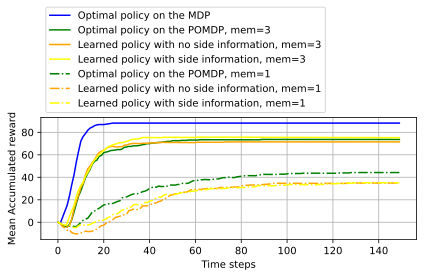

In [17]:
nData = 150
plt.figure()
plot_pol(rewDataMdpOpt_3, nData, color='blue', label='Optimal policy on the MDP', alpha=1, plot_std=False)
plot_pol(rewDataPomdpOpt_3, nData, color='green', label='Optimal policy on the POMDP, mem=3', alpha=0.8, plot_std=False)
# plot_pol(pol_val_scp, color='red', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True)
plot_pol(rewDataPomdpNoSi_3, nData, color='orange', label='Learned policy with no side information, mem=3', alpha = 0.6, plot_std=False)
plot_pol(rewDataPomdpSi_3, nData, color='yellow', label='Learned policy with side information, mem=3', alpha=0.6, plot_std=False)

plot_pol(rewDataPomdpOpt, nData, color='green', linestyle='dashdot', label='Optimal policy on the POMDP, mem=1', alpha=0.8, plot_std=False)
plot_pol(rewDataPomdpNoSi, nData, color='orange', linestyle='dashdot', label='Learned policy with no side information, mem=1', alpha = 0.6, plot_std=False)
plot_pol(rewDataPomdpSi, nData, color='yellow', linestyle='dashdot', label='Learned policy with side information, mem=1', alpha=0.6, plot_std=False)
# plot_pol(rewDataSideInfoLp, color='cyan', label='Learned policy with side information,0.7', alpha=0.2)
plt.ylabel('Mean Accumulated reward')
plt.xlabel('Time steps')
plt.grid(True)
plt.legend(ncol=1, bbox_to_anchor=(0,1), loc='lower left', columnspacing=1.0)
plt.tight_layout()
plt.show()

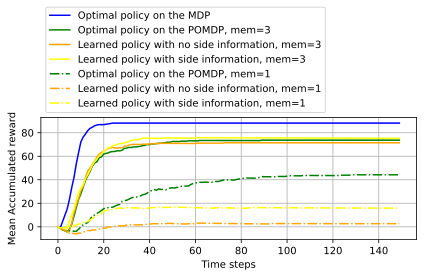

In [99]:
nData = 150
plt.figure()
plot_pol(rewDataMdpOpt_3, nData, color='blue', label='Optimal policy on the MDP', alpha=1, plot_std=False)
plot_pol(rewDataPomdpOpt_3, nData, color='green', label='Optimal policy on the POMDP, mem=3', alpha=0.8, plot_std=False)
# plot_pol(pol_val_scp, color='red', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True)
plot_pol(rewDataPomdpNoSi_3, nData, color='orange', label='Learned policy with no side information, mem=3', alpha = 0.6, plot_std=False)
plot_pol(rewDataPomdpSi_3, nData, color='yellow', label='Learned policy with side information, mem=3', alpha=0.6, plot_std=False)

plot_pol(rewDataPomdpOpt, nData, color='green', linestyle='dashdot', label='Optimal policy on the POMDP, mem=1', alpha=0.8, plot_std=False)
plot_pol(rewDataPomdpNoSi_10, nData, color='orange', linestyle='dashdot', label='Learned policy with no side information, mem=1', alpha = 0.6, plot_std=False)
plot_pol(rewDataPomdpSi_10, nData, color='yellow', linestyle='dashdot', label='Learned policy with side information, mem=1', alpha=0.6, plot_std=False)
# plot_pol(rewDataSideInfoLp, color='cyan', label='Learned policy with side information,0.7', alpha=0.2)
plt.ylabel('Mean Accumulated reward')
plt.xlabel('Time steps')
plt.grid(True)
plt.legend(ncol=1, bbox_to_anchor=(0,1), loc='lower left', columnspacing=1.0)
plt.tight_layout()
plt.show()

In [71]:
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [67]:
import stormpy
import stormpy.simulator
import re

def parse_state_repr(state_repr):
    str_v = re.findall('s=[0-9]*', state_repr)[0]
    return str_v.split('=')[1]

def gen_traj(sigma, pomdp, max_run, max_iter_per_run, obs_based=True):
    rand_seed = np.random.randint(0, 10000)
    simulator = stormpy.simulator.create_simulator(pomdp.pomdp, seed=rand_seed)
    res_traj = list()
    for i in range(max_run):
        # Initialize the simulator
        obs, reward = simulator.restart()
        current_state = simulator._report_state()
        # Save the sequence of states
        seq_obs = []
        for j in range(max_iter_per_run):
            # Get the list of available actions
            actList = [a for a in simulator.available_actions()]
            # Add the observaion, action to the sequence
            if obs_based:
                # Pick an action in the set of random actions with probability given by the policy
                act = np.random.choice(np.array([a for a in sigma[obs]]),p=np.array([probA for a, probA in sigma[obs].items()]))
            else:
                # Pick an action in the set of random actions with probability given by the
                act = np.random.choice(np.array([a for a in sigma[current_state]]), p=np.array([probA for a, probA in sigma[current_state].items()]))
            # Update the state of the simulator
            obs, reward = simulator.step(actList[act])
            current_state = simulator._report_state()
            seq_obs.append(parse_state_repr(pomdp.string_repr_state(current_state)))
            # Check if reaching a looping state
            if simulator.is_done():
                break
        res_traj.append(seq_obs)
    return res_traj

In [80]:
from maze_sim_vizu import *
import re

traj_mdp = gen_traj(pol_val_mdp, pomdp_r, 25, 200, obs_based=False)
mDemo = MazeDemo(maze_repr_14, goal_maze_14, lava_maze_14, soft_lava_maze_14, start_pos='0')
tile_size = 64
frames_mdp = list()
for traj in traj_mdp:
    initState, *rList = traj
    mDemo.set_initial_state(initState)
    frames_mdp.append(mDemo.render('rgb_array', tile_size=tile_size, highlight=True))
    for state in rList:
        mDemo.update_pos(state)
        frames_mdp.append(mDemo.render('rgb_array', tile_size=tile_size, highlight=True))
display_video(frames_mdp, framerate=5)

In [82]:
traj_pomdp = gen_traj(pol_val_grb_nosi, pomdp_r, 10, 150, obs_based=True)
mDemo = MazeDemo(maze_repr_14, goal_maze_14, lava_maze_14, soft_lava_maze_14, start_pos='0')
tile_size = 64
frames_mdp = list()
for traj in traj_pomdp:
    initState, *rList = traj
    mDemo.set_initial_state(initState)
    frames_mdp.append(mDemo.render('rgb_array', tile_size=tile_size, highlight=True))
    for state in rList:
        mDemo.update_pos(state)
        frames_mdp.append(mDemo.render('rgb_array', tile_size=tile_size, highlight=True))
display_video(frames_mdp, framerate=5)

In [84]:
traj_pomdp_3 = gen_traj(pol_val_grb_nosi_3, pomdp_r_3, 10, 150, obs_based=True)
mDemo = MazeDemo(maze_repr_14, goal_maze_14, lava_maze_14, soft_lava_maze_14, start_pos='0')
tile_size = 64
frames_mdp = list()
for traj in traj_pomdp_3:
    initState, *rList = traj
    mDemo.set_initial_state(initState)
    frames_mdp.append(mDemo.render('rgb_array', tile_size=tile_size, highlight=True))
    for state in rList:
        mDemo.update_pos(state)
        frames_mdp.append(mDemo.render('rgb_array', tile_size=tile_size, highlight=True))
display_video(frames_mdp, framerate=5)

In [87]:
traj_pomdp_3_nosi = gen_traj(pol_pomdp_30_3, pomdp_r_3, 10, 150, obs_based=True)
mDemo = MazeDemo(maze_repr_14, goal_maze_14, lava_maze_14, soft_lava_maze_14, start_pos='0')
tile_size = 64
frames_mdp = list()
for traj in traj_pomdp_3_nosi:
    initState, *rList = traj
    mDemo.set_initial_state(initState)
    frames_mdp.append(mDemo.render('rgb_array', tile_size=tile_size, highlight=True))
    for state in rList:
        mDemo.update_pos(state)
        frames_mdp.append(mDemo.render('rgb_array', tile_size=tile_size, highlight=True))
display_video(frames_mdp, framerate=5)